# BirdFlock

Este ejemplo pretende simular el comportamiento de una bandada de pájaros: cientos, o incluso miles, de pájaros volando juntos, formando formas infinitas como si fueran una sola entidad. Para el desarrollo de este ejemplo, nos basaremos en el trabajo presentado por [Rohola Zandie](https://betterprogramming.pub/boids-simulating-birds-flock-behavior-in-python-9fff99375118).


## ¿Cómo funciona el modelo?

Una propuesta de solución a este problema fue presentado por Craig Reynolds cuando introdujo un sistema conocido como "Boids" que podía simular algo similar al comportamiento de bandadas de aves. Su modelo estable tres reglas simples:

- **Separación**: La separación es necesaria para que nuestros individuos choquen entre sí y se estrellen. Cada individuos debe ver a sus propios compañeros de bandada locales y alejarse si están demasiado cerca.
<center>
<img src="https://miro.medium.com/max/217/1*vcc16ijg_e8lMOTRIhhm9w.gif" />
</center>
- **Alineación**: Cada invidividuo solo ve a los individuos que están a su alrededor. Para la alineación, miramos los vecinos y calculamos su dirección promedio (que es parte del vector de velocidad) y seguimos eso.
<center>
<img src="https://miro.medium.com/max/217/1*e8AAGeLm9x0i6kkO4_Yenw.gif" />
</center>
- **Cohesión**: Significa dirigirse hacia el centro de masa de los compañeros de bandada locales. Hacemos esto para forzar a que los individuos se peguen entre sí y no se dividan.
<center>
<img src="https://miro.medium.com/max/217/1*Au6eWj6jETcbVAbQWJR1-g.gif" />
</center>


A diferencia de otros ejemplos, no queremos realizar una animación basada en una matriz sino en objetos que se mueven libremente en un espacio bidimencional.


## Imports


In [109]:
# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
# Cada modelo puede contener múltiples agentes.
from mesa import Agent, Model 

# Con ''SimultaneousActivation, hacemos que todos los agentes se activen ''al azar''.
from mesa.time import RandomActivation
from mesa.space import ContinuousSpace 

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

In [110]:
class FlockAgent(Agent):
    def __init__(self, id, model, x, y):
        super().__init__(id, model)

        self.position = np.array((x, y), dtype=np.float64)

        vec = (np.random.rand(2) - 0.5) * 10
        self.velocity = np.array(vec, dtype=np.float64)

        vec = (np.random.rand(2) - 0.5) / 2
        self.acceleration = np.array(vec, dtype=np.float64)

        self.max_force = 0.3

        self.max_speed = 5

        self.perception = 50

        self.neighbors = None

    
    def step(self):
        self.check_edges()

        self.check_with_neighbors()

        self.position += self.velocity
        self.velocity += self.acceleration

        if np.linalg.norm(self.velocity) > self.max_speed:
            self.velocity = self.velocity / (np.linalg.norm(self.velocity) * self.max_speed)

        self.acceleration = np.array([0, 0], dtype=np.float64)

        self.model.grid.move_agent(self, self.position)

    def check_edges(self):
        if self.position[0] > self.model.grid.x_max:
            self.position[0] = self.model.grid.x_min
        elif self.position[0] < self.model.grid.x_min:
            self.position[0] = self.model.grid.x_max

        if self.position[1] > self.model.grid.y_max:
            self.position[1] = self.model.grid.y_min
        elif self.position[1] < self.model.grid.y_min:
            self.position[1] = self.model.grid.y_max

    def check_with_neighbors(self):
        self.neighbors = self.model.grid.get_neighbors(self.position, radius=self.perception, include_center=False)
        
        aligment = self.align()
        cohesion = self.cohesion()
        separation = self.separation()

        self.acceleration += (aligment + cohesion + separation)

    def align(self):
        total = 0
        steering = np.array([0, 0], dtype=np.float64)
        avg_vector = np.array([0, 0], dtype=np.float64)

        for agent in self.neighbors:
            avg_vector += agent.velocity
            total += 1

        if total > 0:
            avg_vector /= total
            avg_vector = avg_vector / (np.linalg.norm(avg_vector) * self.max_speed)
            steering = avg_vector - self.velocity

        return steering

    def cohesion(self):
        total = 0 
        steering = np.array([0, 0], dtype=np.float64)
        center_of_mass = np.array([0, 0], dtype=np.float64)

        for agent in self.neighbors:
            center_of_mass += agent.position
            total += 1

        if total > 0:
            center_of_mass / total
            vec_to_com = center_of_mass - self.position
            if np.linalg.norm(vec_to_com) > 0:
                vec_to_com = vec_to_com / (np.linalg.norm(vec_to_com) * self.max_speed)

            steering = vec_to_com - self.velocity
            if np.linalg.norm(steering) > self.max_force:
                steering = steering / (np.linalg.norm(steering) * self.max_force)

        return steering
    
    def separation(self):
        total = 0
        steering = np.array([0, 0], dtype=np.float64)
        avg_vector = np.array([0, 0], dtype=np.float64)

        for agent in self.neighbors:
            if not(np.array_equal(self.position, agent.position)):
                diff = (self.position - agent.position) / np.linalg.norm(self.position - agent.position)
                avg_vector += diff
                total += 1

        if total > 0:
            avg_vector /= total
            if np.linalg.norm(avg_vector) > 0:
                avg_vector = avg_vector / (np.linalg.norm(avg_vector) * self.max_speed)

            steering = avg_vector - self.velocity
            if np.linalg.norm(steering) > self.max_force:
                steering = steering / (np.linalg.norm(steering) * self.max_force)
                
        return steering

In [111]:
def get_particles(model):
    result = []
    for agent in model.schedule.agents:
        result.append(agent.position)
    return np.asarray(result)

In [112]:
class FlockModel(Model):
    def __init__(self, num_agents, x_max, y_max):
        super().__init__()
        self.schedule = RandomActivation(self)
        self.grid = ContinuousSpace(x_max, y_max, torus=True)
        self.datacollector = DataCollector(model_reporters={"Particles":get_particles})

        for i in range(num_agents):
            x = np.random.rand() * x_max
            y = np.random.rand() * y_max
            agent = FlockAgent(i, self, x, y)
            self.schedule.add(agent)
            self.grid.place_agent(agent, (x, y))

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [113]:
XMAX = 1000
YMAX = 1000
NUM_AGENTS = 200
ITERATIONS = 2000

model = FlockModel(NUM_AGENTS, XMAX, YMAX)
for i in range(ITERATIONS): 
    model.step()
    

C:\Users\pomar\AppData\Local\Temp\ipykernel_27724\1919088439.py:68: RuntimeWarning: invalid value encountered in divide
  avg_vector = avg_vector / (np.linalg.norm(avg_vector) * self.max_speed)


In [114]:
all_positions = model.datacollector.get_model_vars_dataframe()

C:\Users\pomar\AppData\Local\Temp\ipykernel_27724\354525978.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scatter = ax.scatter(all_positions.iloc[0][0][:, 0], all_positions.iloc[0][0][:, 1], s=10, edgecolor= "k")
C:\Users\pomar\AppData\Local\Temp\ipykernel_27724\354525978.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scatter.set_offsets(all_positions.iloc[i][0])


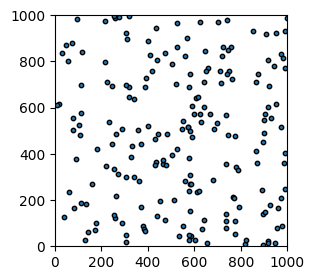

In [115]:
fig, ax = plt.subplots(figsize=(3, 3))
scatter = ax.scatter(all_positions.iloc[0][0][:, 0], all_positions.iloc[0][0][:, 1], s=10, edgecolor= "k")

ax.axis([0, XMAX, 0, YMAX]) # cuadrante de 0 a x max y de 0 a y max

def animate(i):
    scatter.set_offsets(all_positions.iloc[i][0])
    return scatter

anim=animation.FuncAnimation(fig, animate, frames=ITERATIONS)  